## Business Goal 

Enhance the reach and impact of content shared on "MakeupAddiction" by predicting the popularity of posts, thus enabling creators and brands to engage more effectively with their audience.In this section, our primary focus will be on predicting the score of a submission. By analyzing the contributing factors to the model, we aim to impart insights into what is crucial when posting high-score in the MakeupAddiction subreddit.

## Technical Goal

We will extract and engineer several features from our dataset: Post Length, Makeup Theme, Posting Hour, Categorical Features, Creator Popularity, and Text Length. A Gradient Boosted Regressor and Random Forest Regressor will be employed as the supervised regression model, trained on these features with the objective of predicting the `score` of a post, which serves as our popularity metric. We will partition the data into training and validation sets to evaluate the model’s generalizability. Performance will be assessed using the root-mean-square error (RMSE) metric and R Square metric. Lower RMSE scores will be indicative of more accurate predictions of post popularity. Higher R square means larger proportion of the variability in the target variable is accounted for by the model.This strategy aims to optimize engagement by aligning content creation with data-driven predictions.

In [ ]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

%pip install plotly
%pip install tabulate

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [43]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import pandas as pd

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import plotly.express as px
from tabulate import tabulate
from pyspark.ml import PipelineModel

In [4]:
spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cb5b606a-59fe-4a7c-b29e-095afb638a8a;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 656ms :: artifacts dl 23ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

In [5]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")
sampled_submissions = submissions.sample(withReplacement=False, fraction=0.1, seed=123)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-861795727138/project/submissions/yyyy=*


23/11/28 01:52:36 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/11/28 01:52:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 95,932x68
CPU times: user 2.33 s, sys: 178 ms, total: 2.5 s
Wall time: 5min 10s


In [6]:
sampled_topcreators= pd.read_csv('../../data/csv/sampled_Top100Creators.csv')
sampled_topcreators= sampled_topcreators['author'].to_list()

In [7]:

sampled_submissions_var= sampled_submissions.withColumn("created_hour",F.hour(F.to_timestamp(F.col("created_utc").cast('int'))))\
                                            .withColumn('text_length',F.length(F.col('selftext')))\
                                            .withColumn("title_length", F.length(F.col("title")))\
                                            .withColumn("is_top_100_creator", F.col("author").isin(sampled_topcreators))\
                                            .withColumn("is_peak_hour", F.col("created_hour").isin([16, 17, 18, 19, 20, 21, 22, 23, 0]))\
                                            .withColumn("has_media", F.col("media").isNotNull() | F.col("media_embed").getField('content').isNotNull())\
                                            .withColumn("is_long_text",(F.col('text_length') > 200))


# Dummy submissions varaibles
sampled_submissions_var= sampled_submissions_var.withColumn("skincare",F.col("selftext").rlike("""(?i)body|(?i)hair|(?i)facial|(?i)nails|(?i)lip|(?i)sunscreen|(?i)SPF|(?i)acne|(?i)pimples|(?i)scar|(?i)aging"""))\
                                  .withColumn("skincare_product",F.col("selftext").rlike("""(?i)moisturizer|(?i)cleanser|(?i)serum|(?i)toner|(?i)lotion"""))\
                                  .withColumn("skincare_product_brand",F.col("selftext").rlike("""(?i)Clinique|(?i)Neutrogena|(?i)Cetaphil|(?i)Kiehl's|(?i)Olay"""))\
                                  .withColumn("makeup",F.col("selftext").rlike("""(?i)beauty|(?i)bodypaint|(?i)cosmetics|(?i)style|(?i)artist|(?i)cosplay|(?i)fashion|(?i)celebrity|(?i)party|(?i)wedding|(?i)palette"""))\
                                  .withColumn("makeup_product",F.col("selftext").rlike("""(?i)eyeliner|(?i)contour|(?i)foundation|(?i)blush|(?i)lipstick|(?i)concealer"""))\
                                  .withColumn("makeup_product_brand",F.col("selftext").rlike("""(?i)MAC|(?i)NARS|(?i)Sephora|(?i)Fenty|(?i)Revlon|(?i)NYX|(?i)L'Oreal|(?i)Maybelline"""))


In [8]:
# List of columns to select as independent variables
independent_vars = [
    "is_top_100_creator", "text_length", "title_length", "archived", "is_peak_hour", "gilded", "hidden", "hide_score", "is_crosspostable",
    "is_reddit_media_domain", "is_self", "is_video", "num_crossposts", "over_18", "has_media", "pinned", "score",
    "spoiler", "stickied", "is_long_text", "skincare",
    "skincare_product", "skincare_product_brand", "makeup", "makeup_product",
    "makeup_product_brand","num_comments"
]

# Selecting the independent variables from the DataFrame
sampled_sub_ml = sampled_submissions_var.select(independent_vars)

In [9]:
sampled_sub_ml.printSchema()

root
 |-- is_top_100_creator: boolean (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- title_length: integer (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- is_peak_hour: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- hidden: boolean (nullable = true)
 |-- hide_score: boolean (nullable = true)
 |-- is_crosspostable: boolean (nullable = true)
 |-- is_reddit_media_domain: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- has_media: boolean (nullable = false)
 |-- pinned: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- spoiler: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- is_long_text: boolean (nullable = true)
 |-- skincare: boolean (nullable = true)
 |-- skincare_product: boolean (nullable = true)
 |-- skincare_product_brand: boolean (nullable = 

In [29]:
# label and feature columns setup
label_col = "score"
feature_cols = [col for col in sampled_sub_ml.columns if col not in ['score']]

# Split Data
(train_data, test_data) = sampled_sub_ml.randomSplit([0.8, 0.2], seed=42)
train_data.cache()
test_data.cache()

# Create VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

23/11/28 02:40:38 WARN CacheManager: Asked to cache already cached data.


## Model 1 - Random Forest Regressor 

In [11]:
# Create and Train RandomForestRegressor
rf = RandomForestRegressor(labelCol=label_col, featuresCol="features", numTrees=30)

pipeline = Pipeline(stages=[assembler, rf])

# Train the model
model_rf = pipeline.fit(train_data)

## Model 2- Gradient-Boosted Trees (GBT) regressor

In [15]:
# Create GBTRegressor
gbt = GBTRegressor(labelCol=label_col, featuresCol="features", maxIter=30)

pipeline = Pipeline(stages=[assembler, gbt])

# Train the model
model_gbt = pipeline.fit(train_data)

## Results and Comparasion 

In [27]:
# Make predictions on the test set
predictions_rf= model_rf.transform(test_data)
predictions_rf = predictions_rf.select("prediction", label_col)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
mae_rf = evaluator.evaluate(predictions_rf)

evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator.evaluate(predictions_rf)

evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
r2_rf = evaluator.evaluate(predictions_rf)

RandomForestRegressor:
Mean Absolute Error: 64.29881695303378
Root Mean Squared Error: 231.18777300014239
R-squared: 0.7265410321571694


In [30]:
# Make predictions on the test set
predictions_gbt= model_gbt.transform(test_data)
predictions_gbt = predictions_gbt.select("prediction", label_col)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
mae_gbt = evaluator.evaluate(predictions_gbt)

evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
rmse_gbt = evaluator.evaluate(predictions_gbt)

evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
r2_gbt = evaluator.evaluate(predictions_gbt)

23/11/28 02:40:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Gradient-Boosted Trees (GBT) regressor:
Mean Absolute Error: 59.71954489757257
Root Mean Squared Error: 245.67493725127667
R-squared: 0.6911951199787334


In [34]:
# Draw a table to compare the evaluation results of two models
data = [
    ["Random Forest", mae_rf, rmse_rf, r2_rf],
    ["Gradient Boosted Trees", mae_gbt, rmse_gbt, r2_gbt],
]

# Define the headers for the table
headers = ["Model", "MAE", "RMSE", "R-squared"]

# Print the table
table = tabulate(data, headers, tablefmt="pretty")
print(table)

+------------------------+-------------------+--------------------+--------------------+
|         Model          |        MAE        |        RMSE        |     R-squared      |
+------------------------+-------------------+--------------------+--------------------+
|     Random Forest      | 64.29881695303378 | 231.18777300014239 | 0.7265410321571694 |
| Gradient Boosted Trees | 59.71954489757257 | 245.67493725127667 | 0.6911951199787334 |
+------------------------+-------------------+--------------------+--------------------+


Based on the provided metrics:
- The Random Forest model has a slightly higher R-squared value (0.727) compared to the GBT model (0.691), indicating that a higher proportion of the variance in the target variable is explained by the Random Forest model.

- However, the GBT model has a lower MAE (59.72) compared to the Random Forest model (64.30), suggesting that, on average, the predictions from the GBT model are closer to the actual values.

If our primary goal is to minimize prediction errors, especially in terms of Mean Absolute Error (MAE), the GBT model stands out as the preferred choice. The model's accuracy is held in high regard, making it a reliable option. Furthermore, by considering additional factors such as the number of comments, whether the author is among the top creators, and the word count of the submission, we can enhance our ability to predict the submission score with greater precision, bringing our predictions closer to the actual figures.

If our emphasis is on elucidating a greater proportion of variance in the target variable, particularly with regard to R-squared, the Random Forest model emerges as the model of choice. Examining the feature importance of the model enables us to delve into its distribution, offering insights into what factors are crucial for achieving a high score when posting. For instance, becoming a top creator may involve writing more extensive titles and selftext, posting during peak hours, actively engaging with other submissions, and striving to attract a higher number of comments, if feasible.

Consider the trade-offs between different metrics, I will choose Random Forest model, which better fits into our original business goal. 

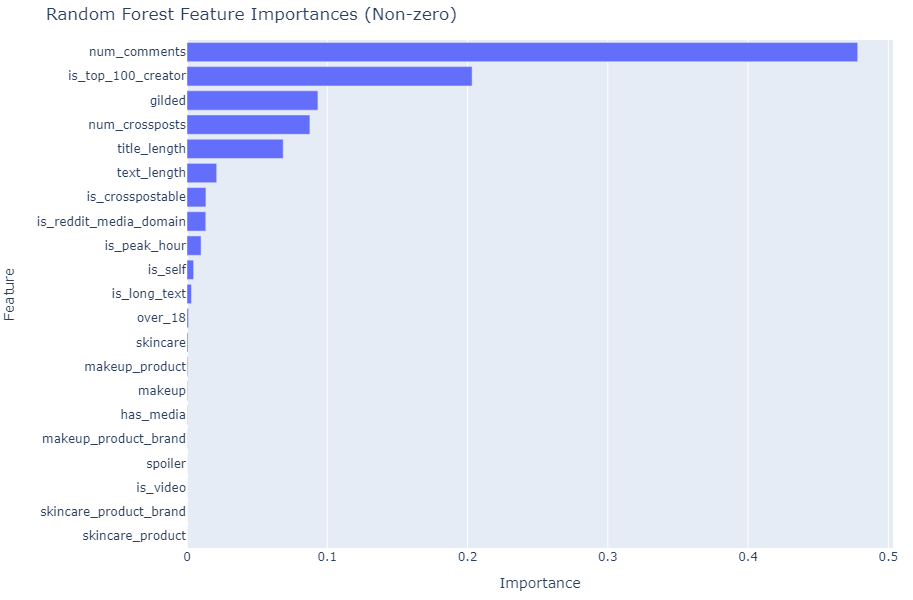

In [38]:
# Get feature importances
feature_importances = model_rf.stages[-1].featureImportances

# Extract feature names
feature_names = assembler.getInputCols()

# Convert SparseVector to dense format
importance_values = feature_importances.toArray()

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})

# Filter out features with zero importance
importance_df_filtered = importance_df[importance_df['Importance'] > 0]

# Sort the DataFrame by importance in descending order
importance_df_filtered = importance_df_filtered.sort_values(by='Importance', ascending=True)

# Create an interactive bar chart using Plotly
fig = px.bar(importance_df_filtered, x='Importance', y='Feature', orientation='h', title='Random Forest Feature Importances (Non-zero)')
fig.update_layout(height=600, width=800, margin=dict(l=20, r=20, t=40, b=40))
fig.write_html("../../data/plots/score_pred_rf_feature_importance_nonzero.html")

fig.show()


1. **Highly Important Features:**
   - `num_comments`: This feature has the highest importance (0.478), indicating that the number of comments on a submission is a crucial factor in predicting the score.

   - `is_top_100_creator`: This feature also has significant importance (0.203), suggesting that whether the creator is in the top 100 contributors is influential.

   - `gilded`: The feature indicating whether the submission received gold awards (`gilded`) is also important (0.093), implying that highly recognized or appreciated posts tend to have higher scores.

   - `num_crossposts`: The number of crossposts (`num_crossposts`) also plays a notable role (0.088) in predicting the score.

2. **Moderate Importance Features:**
   - `title_length`: The length of the submission title contributes moderately (0.069).

   - `is_crosspostable`, `is_reddit_media_domain`: These features related to crossposting and being from Reddit's media domain contribute moderately.

3. **Low Importance Features:**
   - Several features, such as `text_length`, `is_peak_hour`, `is_self`, `is_long_text`, and others, have lower importances but still contribute to the model.

**Interpretation:**
   - The model emphasizes the engagement metrics (`num_comments`, `num_crossposts`, `gilded`) and characteristics of the submission creator (`is_top_100_creator`) as highly influential in predicting the score.

   - Features related to the content of the submission, such as `title_length`, also play a significant role.



In [44]:
# Save the model
model_path = "score_pred_model_rf" 
model_rf.write().overwrite().save(model_path)